# Models without tweets features

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

import missingno as msno
import math

### Load, join and clean datasets

In [2]:
#targets:
#    0: porn
#    1: propaganda
#    2: spam
#    3: fake followers

porn = pd.read_csv('data/porn/users.csv', encoding='utf-8-sig')
porn['target'] = 0

propaganda = pd.read_csv('data/propaganda/users.csv', encoding='utf-8-sig')
propaganda['target'] = 1

spam = pd.read_csv('data/spam/users.csv', encoding='utf-8-sig')
spam['target'] = 2

fake_followers = pd.read_csv('data/fake_followers/users.csv', encoding='utf-8-sig')
fake_followers['target'] = 3
chosen_idx = np.random.choice(8825, replace=False, size=3500)
fake_followers = fake_followers.iloc[chosen_idx]

frames = [porn, propaganda, spam, fake_followers]
users = pd.concat(frames, ignore_index=True)

## Visualize missing values

### Full

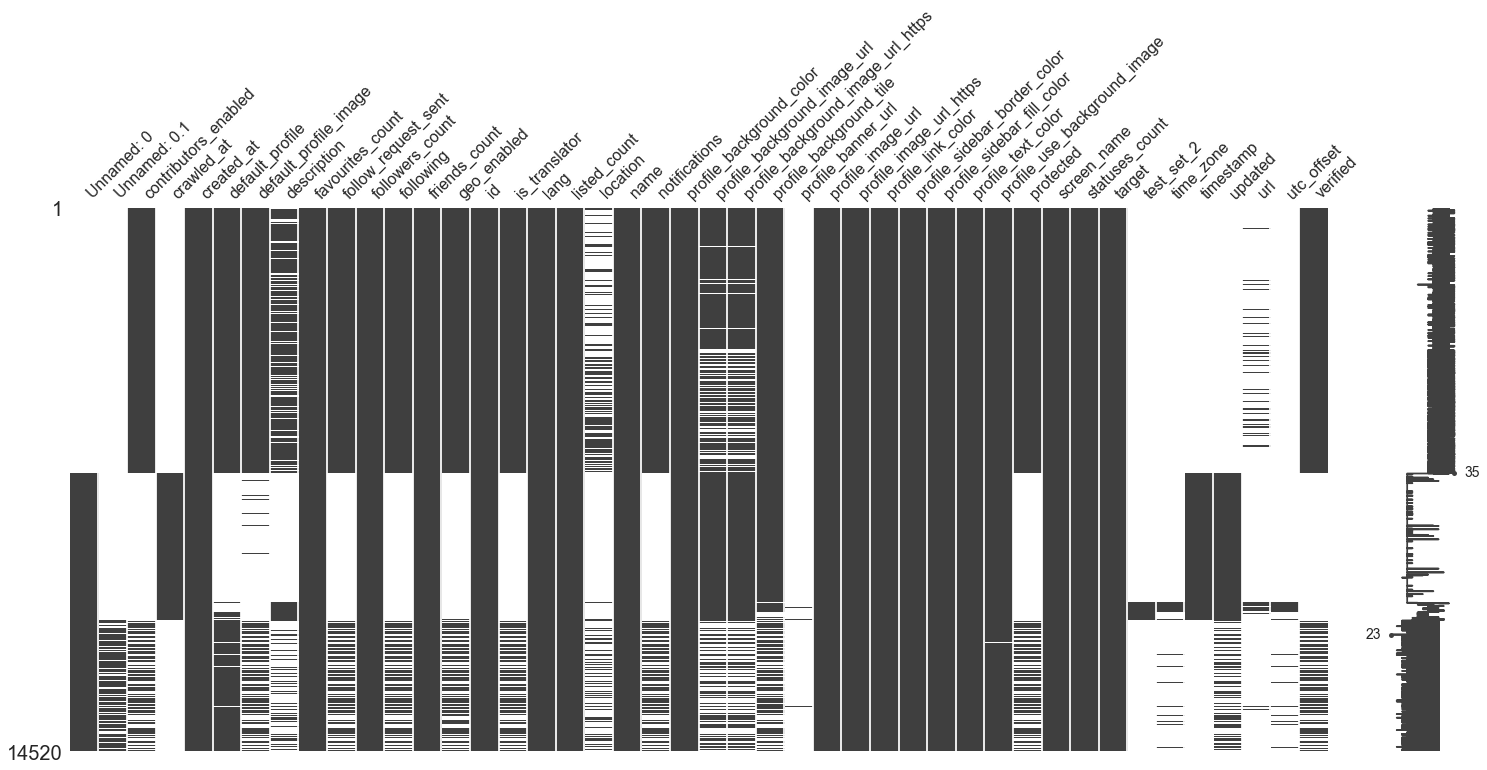

In [3]:
msno.matrix(users)

### Porn Bots

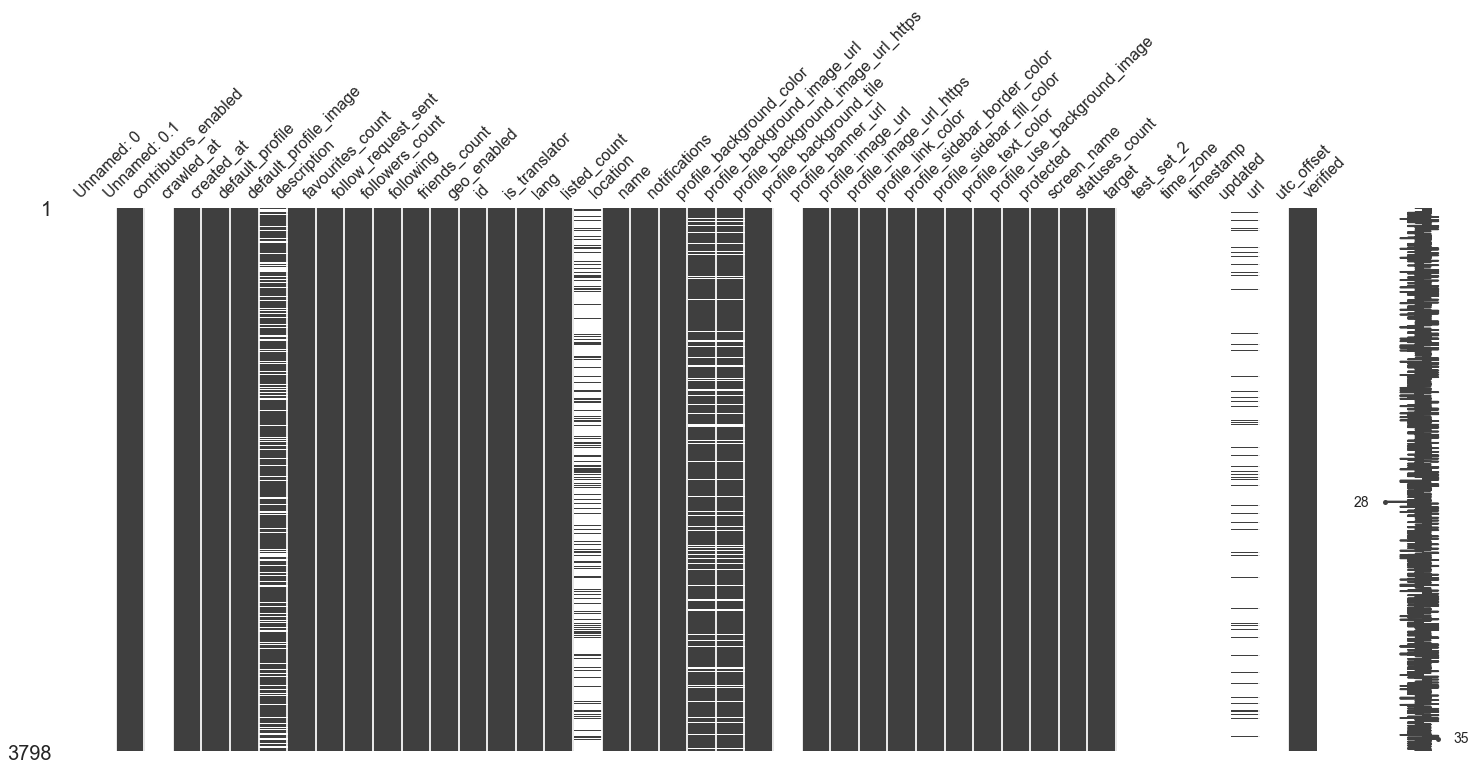

In [4]:
msno.matrix(users[users.target==0])

### Propaganda Bots

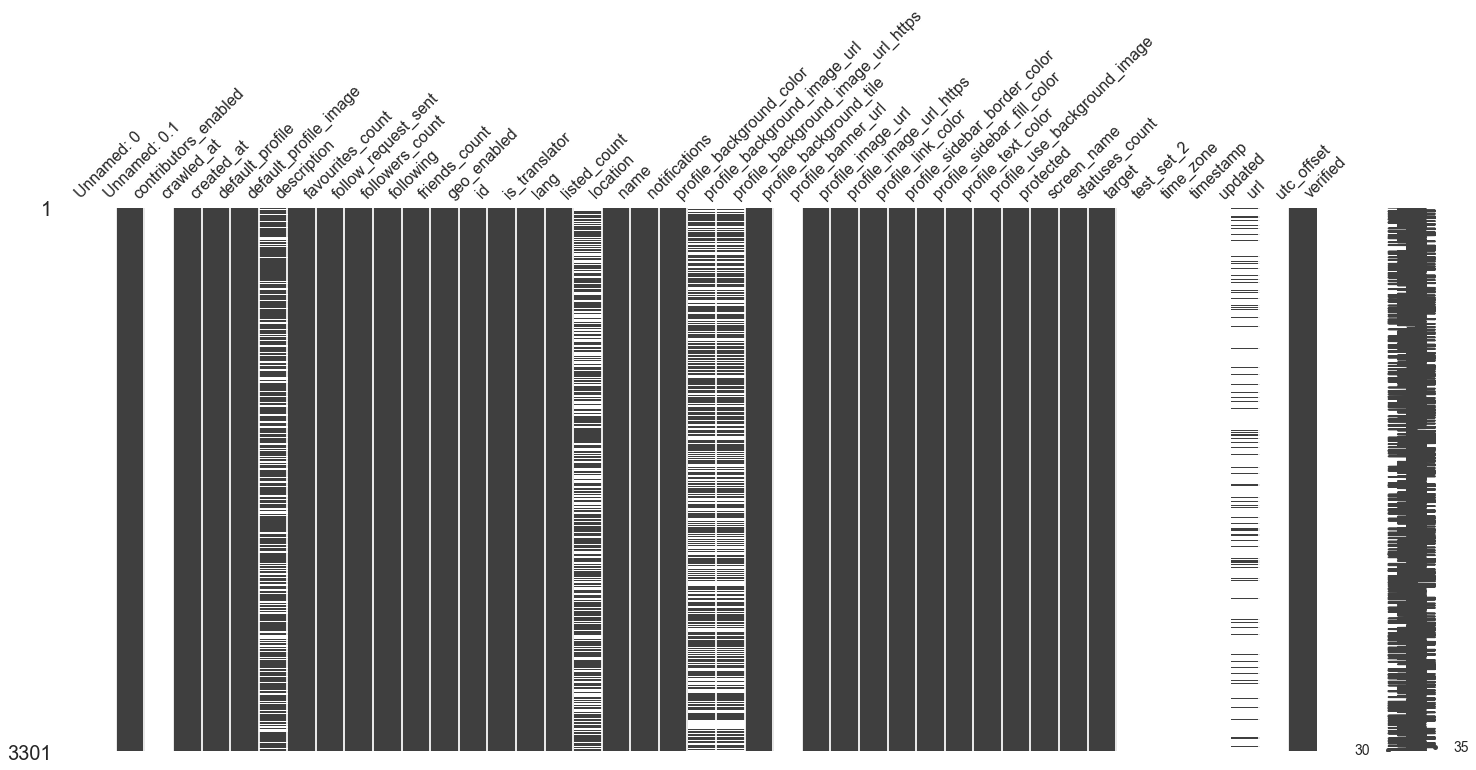

In [5]:
msno.matrix(users[users.target==1])

### Spam Bots

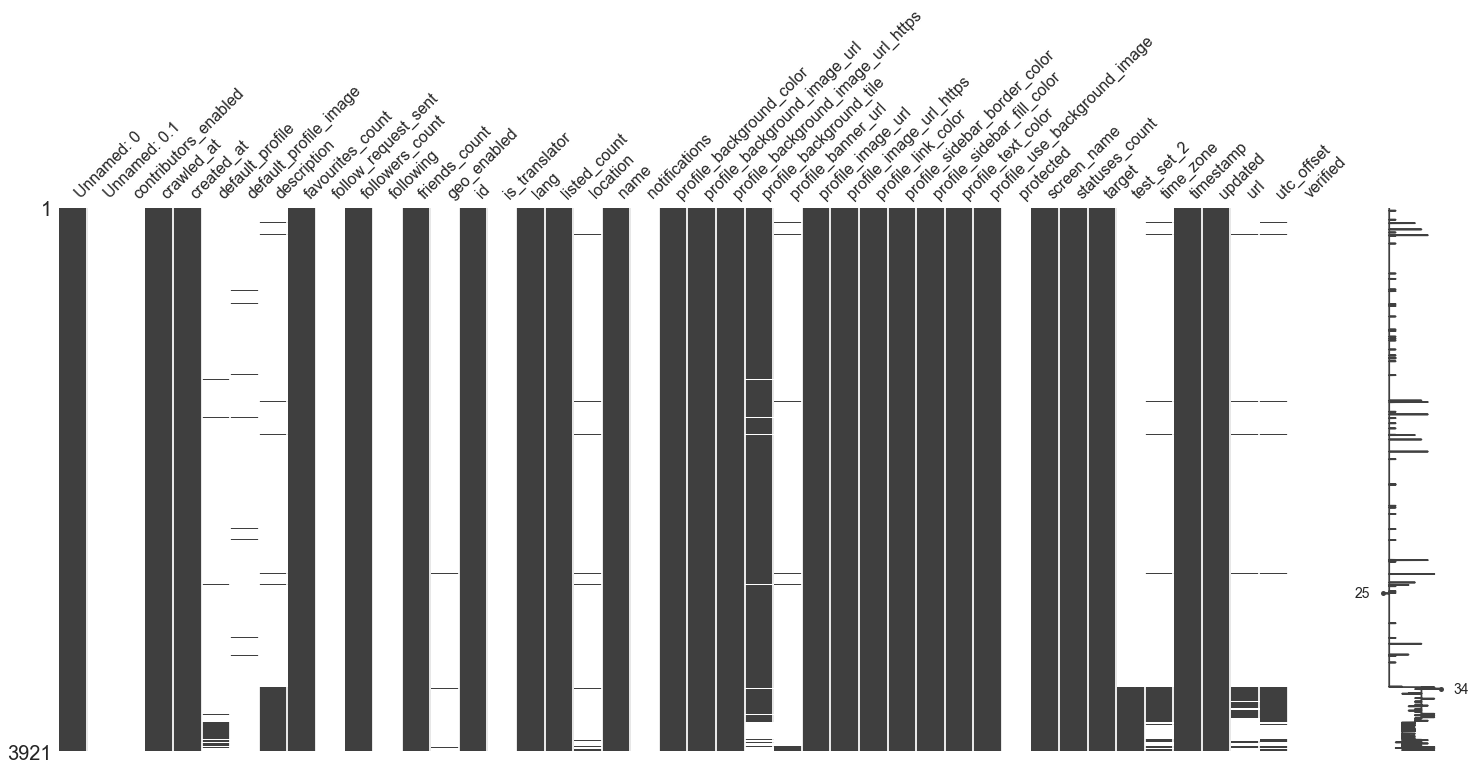

In [6]:
msno.matrix(users[users.target==2])

### Fake Followers

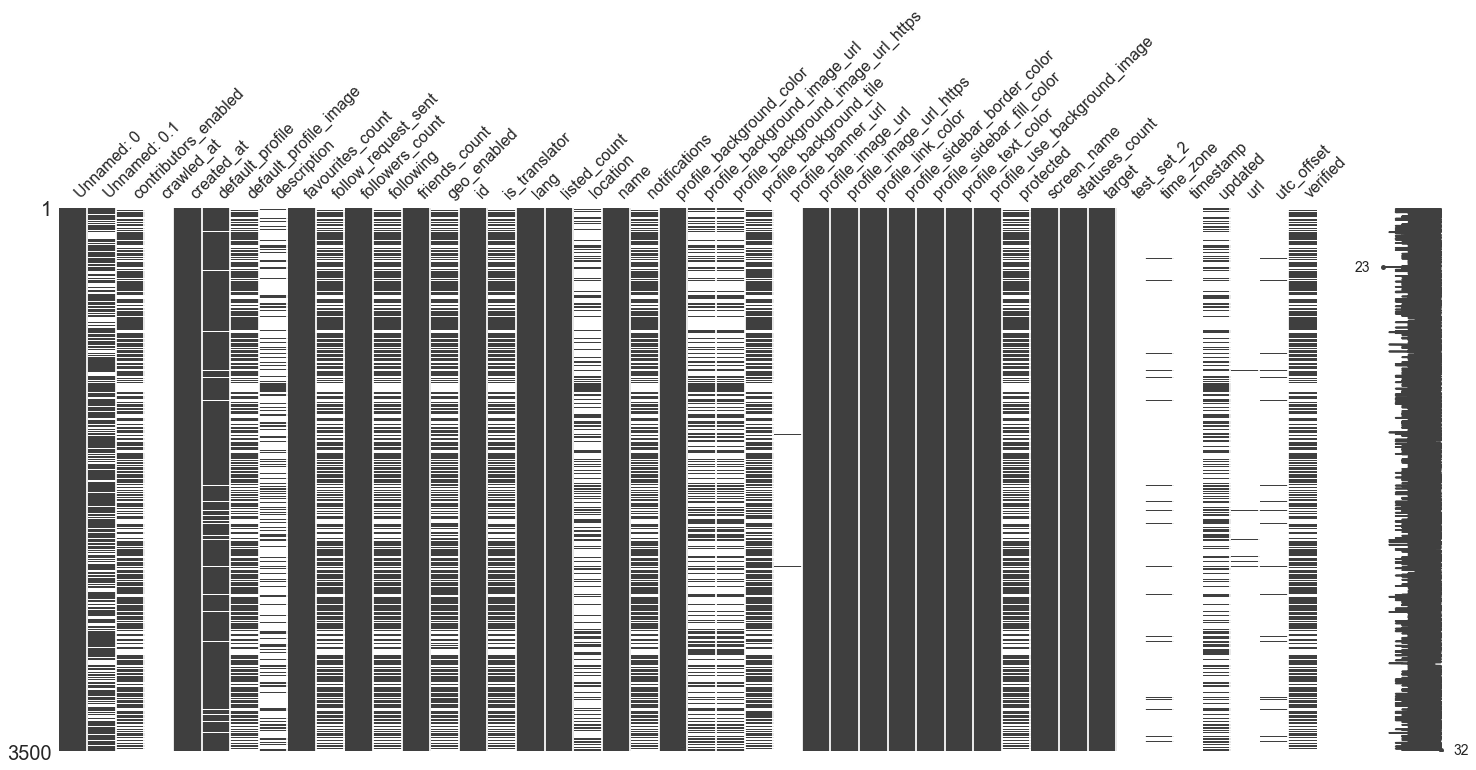

In [7]:
msno.matrix(users[users.target==3])

### remove attributes with a lot of missing values 

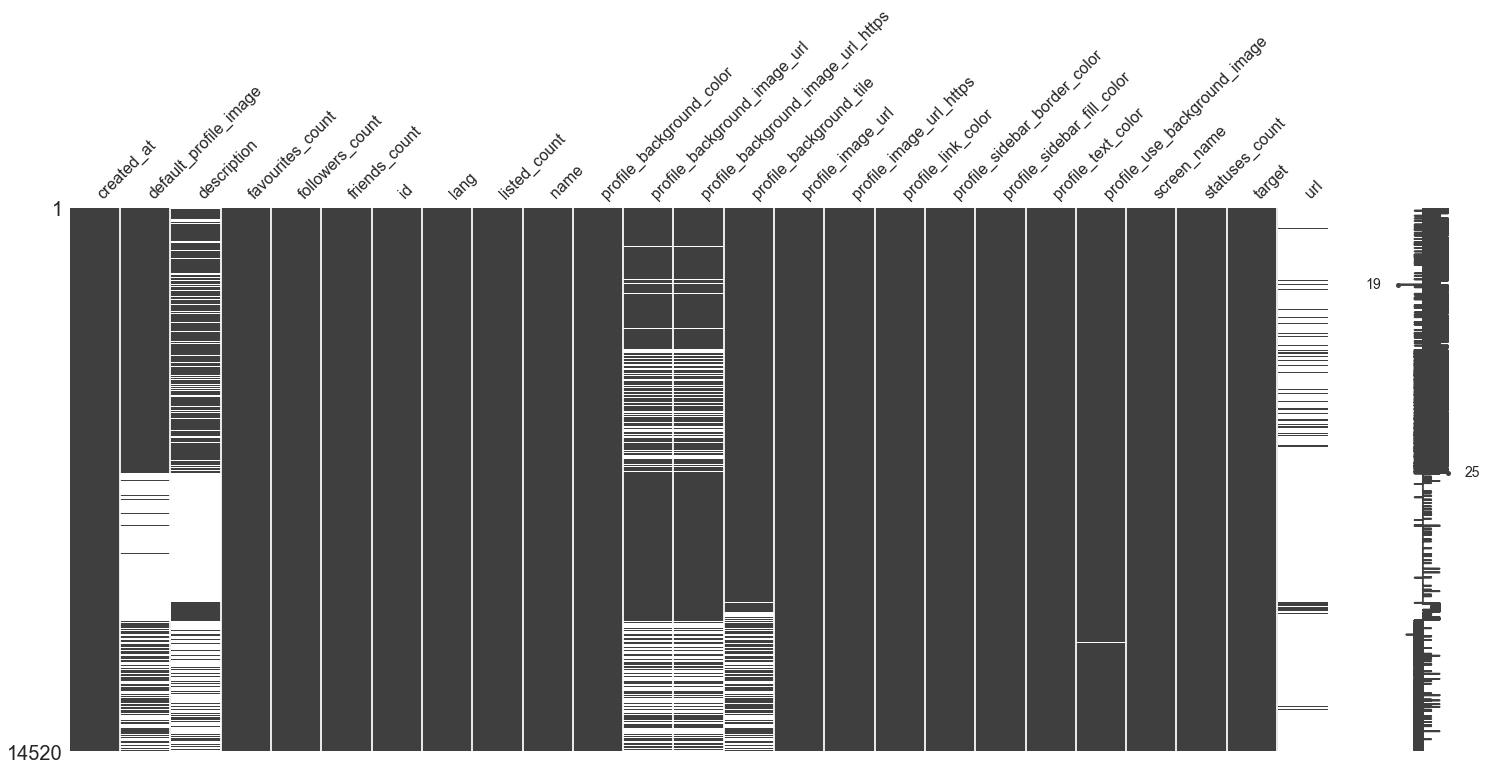

In [8]:
users = users.drop(columns=['default_profile', 'location', 'verified', 'Unnamed: 0', 'Unnamed: 0.1', 'contributors_enabled', 'crawled_at', 'follow_request_sent', 'following', 'geo_enabled', 'is_translator', 'notifications', 'profile_banner_url', 'test_set_2', 'time_zone', 'timestamp', 'updated', 'utc_offset', 'protected'], axis=1)
msno.matrix(users)

Save cleaned dataset

In [9]:
users.to_csv('data/full/users.csv', encoding='utf-8-sig')

### Remove useless attributes

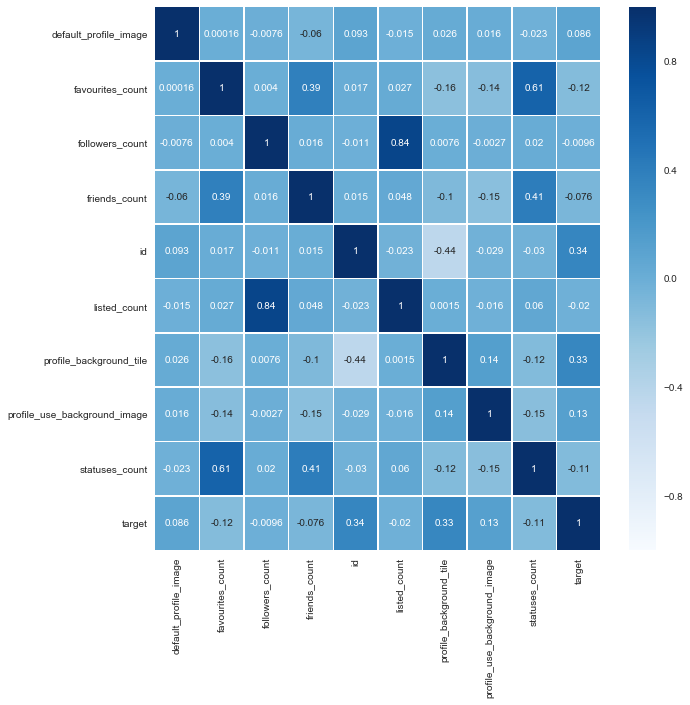

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
cov=users.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Blues",linewidths=.5, ax=ax)

In [11]:
users = users.drop(columns=['id', 'screen_name'], axis=1)

### Fill missing fields

Distribution of missing values

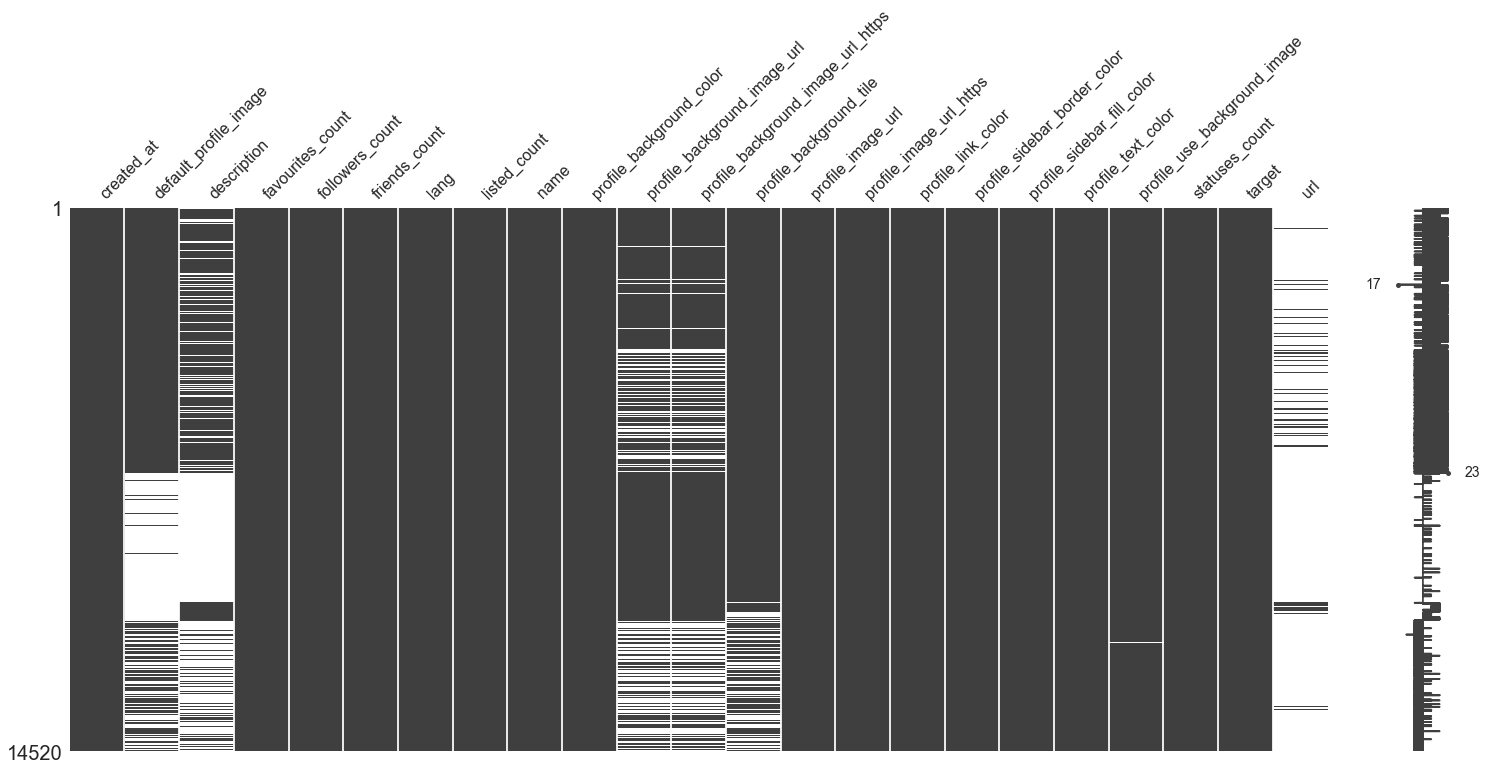

In [12]:
msno.matrix(users)

Fill missing values

In [13]:
users[users.target==2]['default_profile_image'].value_counts()

1.0    46
Name: default_profile_image, dtype: int64

In [14]:
users['default_profile_image'] = users['default_profile_image'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [15]:
users['description'] = users['description'].fillna('')

In [16]:
users['description'] = users['description'].apply(lambda x: len(x))

In [17]:
users[users.target==2]['description'].value_counts()[:10]

0     3447
86      34
55      32
50      30
64      30
89      27
32      23
54      10
62       8
59       8
Name: description, dtype: int64

In [18]:
users['lang'].isnull().values.any()

False

In [19]:
users['profile_background_color'].isnull().values.any()

False

In [20]:
users['profile_background_color'].isnull().values.any()

False

In [21]:
users['profile_background_tile'].isnull().values.any()

True

In [22]:
users['profile_background_tile'] = users['profile_background_tile'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [23]:
users['profile_background_tile'].count()

14520

In [24]:
users['profile_link_color'].isnull().values.any()

False

In [25]:
users['profile_sidebar_border_color'].isnull().values.any()

False

In [26]:
users['profile_sidebar_fill_color'].isnull().values.any()

False

In [27]:
users['profile_text_color'].isnull().values.any()

False

In [28]:
users['profile_use_background_image'].isnull().values.any()

True

In [29]:
users[users.target==2]['profile_use_background_image'].value_counts()

1.0    3918
Name: profile_use_background_image, dtype: int64

In [30]:
users['profile_use_background_image'] = users['profile_use_background_image'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [31]:
users['profile_background_image_url'].isnull().values.any()

True

In [32]:
users['profile_background_image_url'] = users['profile_background_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [33]:
users['profile_background_image_url_https'].isnull().values.any()

True

In [34]:
users['profile_background_image_url_https'] = users['profile_background_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [35]:
users[users.target==3]['url'].isnull().values.any()

True

In [36]:
users['url'] = users['url'].apply(lambda x: int(not(int(pd.isnull(x)))))

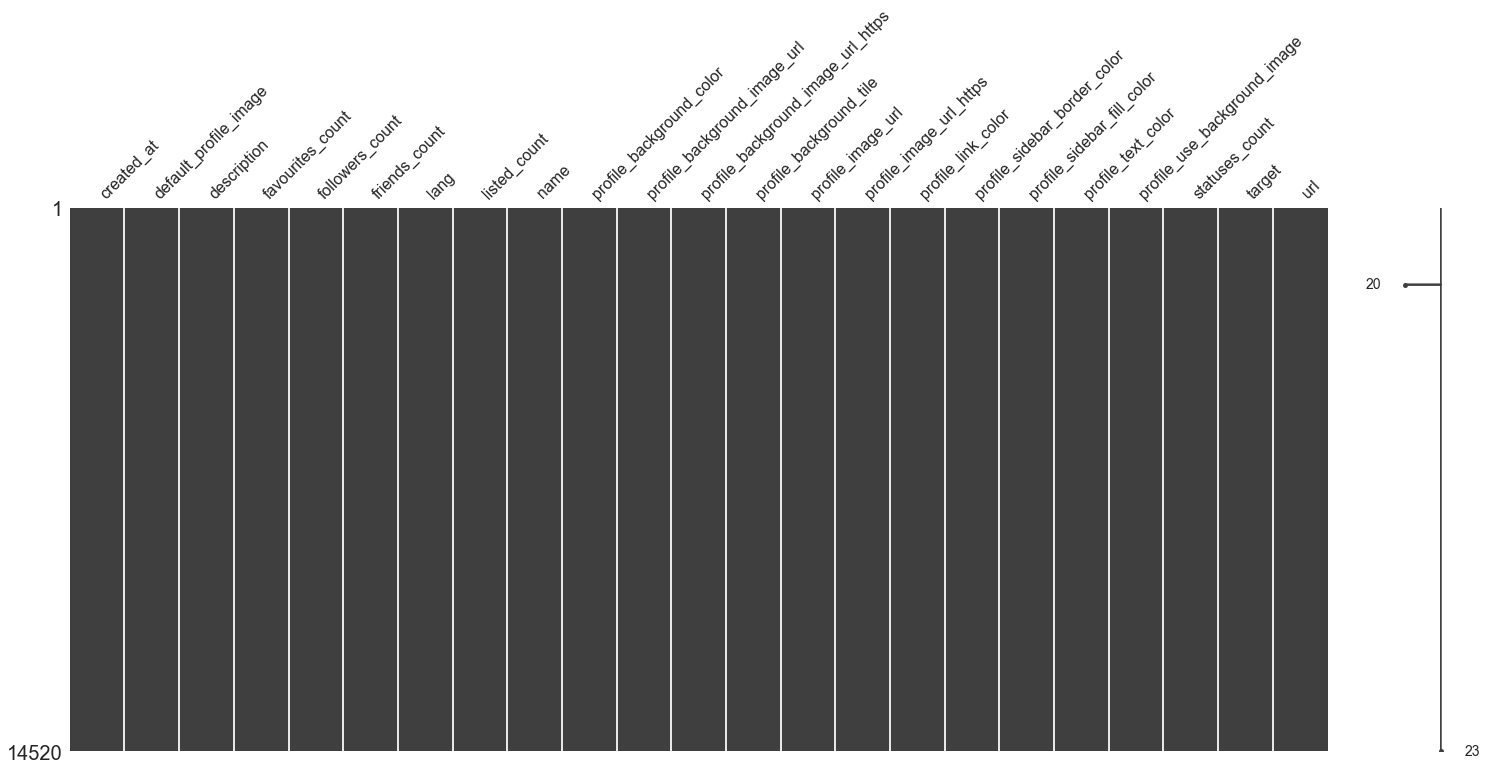

In [37]:
msno.matrix(users)

In [38]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,14520.000000,14520.000000,14520.000000,1.452000e+04,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,1.452000e+04,14520.000000,14520.000000
mean,0.642493,36.691185,9065.800207,1.068284e+04,1444.760606,54.340289,0.741185,0.741185,0.897314,0.999449,1.388044e+04,1.490565,0.073691
std,0.479282,49.019322,33728.543025,4.794182e+05,5657.048729,1195.883456,0.437999,0.437999,0.303559,0.023467,5.180458e+04,1.120371,0.261277
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000e+00,41.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.200000e+01,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.100000e+01,214.000000,0.000000,1.000000,1.000000,1.000000,1.000000,5.600000e+01,2.000000,0.000000
75%,1.000000,58.000000,410.250000,8.800000e+01,627.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.719750e+03,2.000000,0.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,3.000000,1.000000


In [39]:
users.describe(exclude=[np.number])

,created_at,lang,name,profile_background_color,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color
count,14520,14520,14519,14520,14519,14519,14520,14520,14520,14520
unique,14048,42,13879,251,13435,13435,350,125,175,153
top,2018-03-28 20:49:00,en,Live Cam Girls,C0DEED,http://abs.twimg.com/sticky/default_profile_im...,https://abs.twimg.com/sticky/default_profile_i...,1DA1F2,C0DEED,DDEEF6,333333
freq,3,11292,6,5566,625,625,7750,9273,12852,13417


### Create model

### Drop non numeric features

In [40]:
users = users.drop(columns=['created_at', 'lang', 'name', 'profile_background_color', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color'], axis=1)

In [41]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,14520.000000,14520.000000,14520.000000,1.452000e+04,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,1.452000e+04,14520.000000,14520.000000
mean,0.642493,36.691185,9065.800207,1.068284e+04,1444.760606,54.340289,0.741185,0.741185,0.897314,0.999449,1.388044e+04,1.490565,0.073691
std,0.479282,49.019322,33728.543025,4.794182e+05,5657.048729,1195.883456,0.437999,0.437999,0.303559,0.023467,5.180458e+04,1.120371,0.261277
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000e+00,41.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.200000e+01,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.100000e+01,214.000000,0.000000,1.000000,1.000000,1.000000,1.000000,5.600000e+01,2.000000,0.000000
75%,1.000000,58.000000,410.250000,8.800000e+01,627.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.719750e+03,2.000000,0.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,3.000000,1.000000


In [42]:
target = 'target'
features = users.columns[users.columns!=target]

In [43]:
X = users[features]
y = users[target]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [45]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
# Fitting Logistic Regression
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Holdout score - forest

In [51]:
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1     2    3
Actual Target                        
0                 922   24     0    1
1                  16  789     1    0
2                   0    0  1004    4
3                   0    0     4  865


### Most important features

In [56]:
sorted(zip(map(lambda x: round(x, 2), classifier.feature_importances_), users.columns), reverse=True)[:10]

[(0.41999999999999998, 'favourites_count'),
 (0.12, 'statuses_count'),
 (0.089999999999999997, 'followers_count'),
 (0.089999999999999997, 'default_profile_image'),
 (0.080000000000000002, 'friends_count'),
 (0.059999999999999998, 'description'),
 (0.050000000000000003, 'profile_background_image_url'),
 (0.040000000000000001, 'profile_background_image_url_https'),
 (0.029999999999999999, 'profile_background_tile'),
 (0.02, 'listed_count')]

### Holdout score - logistic regression

In [52]:
# Predicting the Test set results
y_pred = logreg.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1    2    3
Actual Target                       
0                 884   31   12   20
1                  37  749   20    0
2                  13   11  984    0
3                   4    1   12  852


## KNN

In [65]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [73]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [74]:
# Predicting the Test set results
y_pred = knn.predict(X_test_n)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1    2    3
Actual Target                       
0                 917   25    0    5
1                  63  740    0    3
2                   4    0  961   43
3                   0    0   18  851


## Cross Validation scores

In [75]:
from sklearn.model_selection import cross_val_score
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1_macro').mean())

In [76]:
## Random forest  /  Logistic Regression  /  KNN
scores

[0.98425081499420075, 0.9107995624308286, 0.94689582913491388]